# ML Demo
Using Datalab + Cloud ML for training & deploying models

### Global Constants

In [1]:
_ = !pip install google-cloud-dataflow

In [2]:
BUCKET = 'gs://' + datalab_project_id() + '-ml-poc-lab'
PREPROCESS_DIR = BUCKET + '/hotdogpreprocessedcloud'
MODEL_DIR = BUCKET + '/hotdogmodelcloud'
STAGING_DIR = BUCKET + '/staging'
IMAGES_DIR = BUCKET + '/images'

### Includes

In [21]:
import google.datalab.bigquery as bq
from google.datalab.ml import CloudTrainingConfig
from google.datalab.ml import ModelVersions
import logging
import matplotlib.pyplot as plt
import mltoolbox.image.classification as model
import pandas as pd
import time
import os

from google.datalab.ml import *
from multiprocessing import Pool
from PIL import Image

### Make scratch bucket

In [4]:
!gsutil mb $BUCKET

Creating gs://strong-moose-ml-poc-lab/...
ServiceException: 409 Bucket strong-moose-ml-poc-lab already exists.


### Get list of images 


In [5]:
%%bq query --name hotdog_dataset
SELECT
  original_url, label_name
FROM
  `bigquery-public-data.open_images.labels` a
INNER JOIN
  `bigquery-public-data.open_images.images` b
ON
  a.image_id = b.image_id
WHERE
  a.label_name='/m/01b9xk'
  AND a.confidence > 0.7
  LIMIT 100


In [6]:
hotdog_dataset_result=hotdog_dataset.execute().result()
#to dataframe
df_hotdog = hotdog_dataset_result.to_dataframe()
#replace labels
df_hotdog['label_name'] = 'hotdog'

In [7]:
%%bq query --name non_hotdog_dataset
SELECT
  original_url, label_name
FROM
  `bigquery-public-data.open_images.labels` a
INNER JOIN
  `bigquery-public-data.open_images.images` b
ON
  a.image_id = b.image_id
WHERE
  (a.label_name='/m/08chc_' 
  OR a.label_name='/m/01j3zr' 
  OR a.label_name='/m/06l9l9' 
  OR a.label_name = '/m/018_zj'
  OR a.label_name = '/m/09z27p'
  OR a.label_name = '/m/025rrgz'
  OR a.label_name = '/m/01xg0j'	
  OR a.label_name = '/m/09z27p'
  OR a.label_name = '/m/01xg0j'	
  OR a.label_name = '/m/0kdzn'
  OR a.label_name = '/m/03f7_0'
  OR a.label_name = '/m/07crc')
  AND a.confidence > 0.70
LIMIT 100


In [8]:
non_hotdog_dataset_result=non_hotdog_dataset.execute().result()
#to dataframe
df_non_hotdog = non_hotdog_dataset_result.to_dataframe()
#replace labels
df_non_hotdog['label_name'] = 'no_hotdog'

### Label the images data

In [9]:
all_images = pd.concat([df_non_hotdog, df_hotdog], ignore_index=True)

### Download the images locally

In [12]:
%%capture --no-stdout --no-display --no-stderr
def download_image(url):
  """Downloads image to local filesystem."""
  _ = !wget --quiet {url} -O {'/content/hotdog/images/' + os.path.basename(url)}

pool = Pool(10)
_ = pool.map(download_image, all_images.original_url)

### Upload images to GCS

In [13]:
%%capture --no-stdout --no-display --no-stderr
_ = !gsutil -m cp -R /content/hotdog/images/* {IMAGES_DIR}/

### Upload Training Dataset

In [14]:
#used to change location of URL to GCS
for index, row in all_images.iterrows():
  url = row['original_url']
  new_url = os.path.join(IMAGES_DIR, os.path.basename(url))
  row['original_url'] = new_url

all_images.to_csv("cloud-training.csv", header=False, index=False)
!gsutil cp cloud-training.csv {BUCKET}

Copying file://cloud-training.csv [Content-Type=text/csv]...
/ [1 files][ 14.2 KiB/ 14.2 KiB]                                                
Operation completed over 1 objects/14.2 KiB.                                     


### Preprocessing the model

In [16]:
# Make sure dataflow is enabled before running
# This will take like ~30mins
train_set = CsvDataSet(BUCKET + '/cloud-training.csv', schema='image_url:STRING, label:STRING')
model.preprocess(train_set, PREPROCESS_DIR, cloud={'num_workers': 10})


[2018-02-02 18:03:12,205] {gcsio.py:388} INFO - Starting the size estimation of the input
[2018-02-02 18:03:12,211] {client.py:614} INFO - Attempting refresh to obtain initial access_token
[2018-02-02 18:03:12,273] {gcsio.py:408} INFO - Finished the size estimation of the input at 1 files. Estimation took 0.0672149658203 seconds
[2018-02-02 18:03:14,497] {direct_runner.py:73} INFO - Running pipeline with DirectRunner.
[2018-02-02 18:03:14,635] {gcsio.py:388} INFO - Starting the size estimation of the input
[2018-02-02 18:03:14,639] {client.py:614} INFO - Attempting refresh to obtain initial access_token
[2018-02-02 18:03:14,710] {gcsio.py:408} INFO - Finished the size estimation of the input at 1 files. Estimation took 0.0749850273132 seconds
[2018-02-02 18:03:14,721] {client.py:614} INFO - Attempting refresh to obtain initial access_token
INFO:tensorflow:Restoring parameters from gs://cloud-ml-data/img/flower_photos/inception_v3_2016_08_28.ckpt
[2018-02-02 18:04:22,325] {tf_logging.py

### Train the Model

In [26]:
# Before running this make sure ML Engine is enabled
# logging.getLogger().setLevel(logging.INFO)
# logging.getLogger().setLevel(logging.WARNING)

# cloud options: http://googledatalab.github.io/pydatalab/google.datalab.ml.html#google.datalab.ml.CloudTrainingConfig 
model.train(PREPROCESS_DIR, 30, 800, MODEL_DIR, cloud=CloudTrainingConfig(
        region="us-central1",
        
        # https://cloud.google.com/ml-engine/reference/rest/v1/projects.jobs#scaletier
        # https://cloud.google.com/ml-engine/pricing
        scale_tier="STANDARD_1"
    ))

Job "image_classification_train_180202_181912" submitted. Click here to view cloud log.

completed


### Model Summary

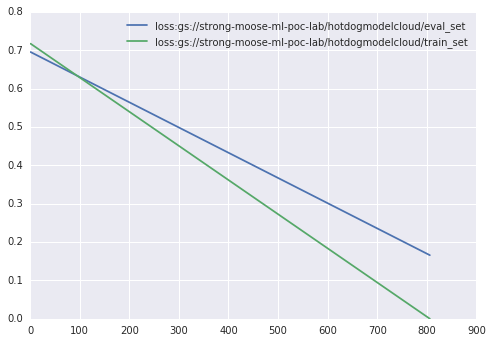

In [28]:
summary = Summary(MODEL_DIR)
summary.plot('loss')

In [31]:
tb_id = TensorBoard.start(MODEL_DIR)

TensorBoard was started successfully with pid 6739. Click here to access it.

### Predict if we have hotdogs!

Predicting...
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
[2018-02-02 18:34:04,620] {tf_logging.py:90} WARNING - The saved meta_graph is possibly from an older release:
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from gs://strong-moose-ml-poc-lab/hotdogmodelcloud/model/variables/variables
[2018-02-02 18:34:04,681] {tf_logging.py:82} INFO - Restoring parameters from gs://strong-moose-ml-poc-lab/hotdogmodelcloud/model/variables/variables


no_hotdog(0.66578)

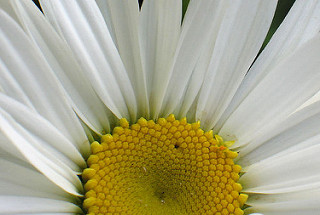

In [33]:
images = ['gs://cloud-ml-data/img/flower_photos/daisy/15207766_fc2f1d692c_n.jpg']
df = model.predict(MODEL_DIR, images, show_image=True)

Predicting...
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
[2018-02-02 18:43:50,840] {tf_logging.py:90} WARNING - The saved meta_graph is possibly from an older release:
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from gs://strong-moose-ml-poc-lab/hotdogmodelcloud/model/variables/variables
[2018-02-02 18:43:50,897] {tf_logging.py:82} INFO - Restoring parameters from gs://strong-moose-ml-poc-lab/hotdogmodelcloud/model/variables/variables


hotdog(1.00000)

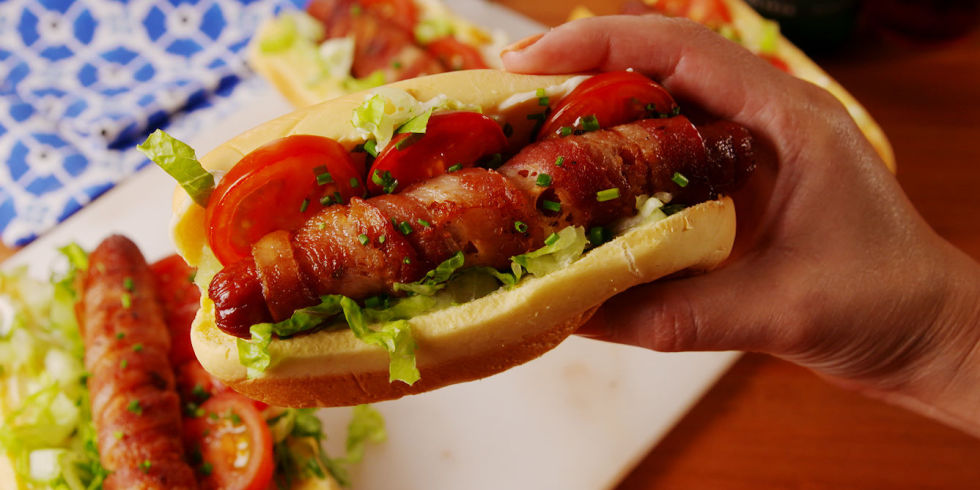

In [48]:
!wget --quiet http://del.h-cdn.co/assets/17/25/980x490/landscape-1498074256-delish-blt-dogs-01.jpg \
  --output-document=/content/hotdog/test/hotdog.jpg

images = [
  '/content/hotdog/test/hotdog.jpg'
]
df = model.predict(MODEL_DIR, images, show_image=True)

### Deploy Model to cloud ml

In [52]:
ModelVersions("hotdog").deploy("v1_0", MODEL_DIR)

Waiting for operation "projects/strong-moose/operations/create_hotdog_v1_0-1517597878620"
Done.


### Predict with Cloud ML

In [56]:
import base64
import urllib
b64img = base64.b64encode(urllib.urlopen(
  'http://del.h-cdn.co/assets/17/25/980x490/landscape-1498074256-delish-blt-dogs-01.jpg'
).read()).decode('ascii')

In [59]:
# Datalab friendly code:
ModelVersions("hotdog").predict("v1_0", [{
      "key": "0",
      "image_bytes": {
        "b64": b64img,
      },
    }])

[{u'key': u'0',
  u'labels': [u'hotdog', u'no_hotdog', u'UNKNOWN'],
  u'prediction': u'hotdog',
  u'scores': [0.9999961853027344,
   3.538686542015057e-06,
   2.5549883275743923e-07]}]

### Cloud ML prediction call from Server

In [66]:
import io
import googleapiclient.discovery
from PIL import Image

# Resize image for faster prediction
buff = Image.open(io.BytesIO(base64.b64decode(b64img)))
size = 1024, 1024
buff.thumbnail(size, Image.ANTIALIAS)
out_buff = io.BytesIO()
buff.convert("RGB").save(out_buff, format="JPEG")
out_buff.seek(0)
smaller_img = base64.b64encode((out_buff.getvalue())).decode("ascii")

# Send API Request
service = googleapiclient.discovery.build("ml", "v1")
resp = service.projects().predict(
  name="projects/" + datalab_project_id() + "/models/hotdog/versions/v1_0",
  body={
    "instances": [{
      "key": "0",
      "image_bytes": {
        "b64": smaller_img,
      },
    }]
  }).execute()
print resp

{u'predictions': [{u'labels': [u'hotdog', u'no_hotdog', u'UNKNOWN'], u'prediction': u'hotdog', u'key': u'0', u'scores': [0.9999958276748657, 3.9121964618971106e-06, 2.6576128675515065e-07]}]}
